# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [3]:
from keras.datasets import cifar100

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)

Number of unique classes: 100


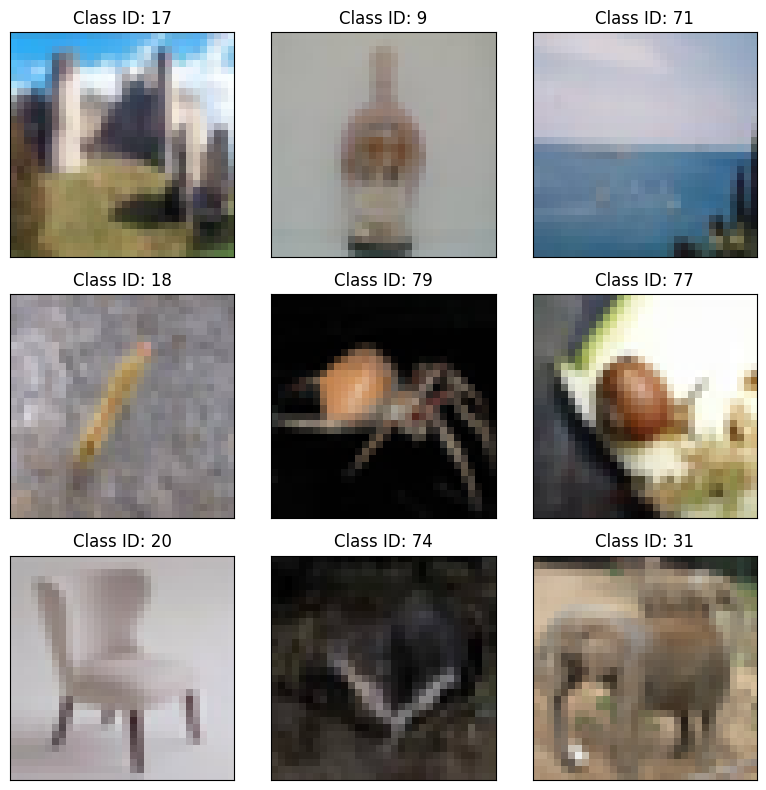

In [4]:
# Your code here
import matplotlib.pyplot as plt
import numpy as np

# Dataset shapes
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Number of classes
num_classes = len(np.unique(y_train))
print(f"\nNumber of unique classes: {num_classes}")

# Selecting 9 random indices
random_indices = np.random.choice(len(x_train), 9, replace=False)

# Creating a 3x3 grid plot
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[random_indices[i]])  # Display the image
    ax.set_title(f"Class ID: {y_train[random_indices[i]][0]}")  # Show the class ID as the title

    # Removing axis labels
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

### 1b: Data Preprocessing (4 Marks)
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [5]:
# Your code here

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Normalizing the images (scaling pixel values to the range [0, 1])
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert the labels to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=100)
y_test = to_categorical(y_test, num_classes=100)

# Splitting the training set into training and validation sets (80% train, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Output the shapes of the resulting datasets
print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")


Training data shape: (40000, 32, 32, 3)
Validation data shape: (10000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Training labels shape: (40000, 100)
Validation labels shape: (10000, 100)
Test labels shape: (10000, 100)


## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Your code here
# Create a baseline CNN model
model = Sequential()

# Add convolutional layers and max-pooling layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for the dense layers
model.add(Flatten())

# Add dense layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          25,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 643,492 (2.45 MB)

 Trainable params: 643,492 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different.
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> ______
- <b>Optimizer:</b> ______

In [7]:
from keras import optimizers

# Your code here
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),  # Optimizer
    loss='categorical_crossentropy',  # Loss function
    metrics=['accuracy']  # Metrics to monitor during training
)

## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [8]:
# Your code here
history = model.fit(
    x_train, y_train,  # Training data
    batch_size=32,  # Batch size
    epochs=20,  # Number of epochs
    validation_data=(x_val, y_val),  # Validation data
    verbose=1  # Print progress during training
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.0387 - loss: 4.3424 - val_accuracy: 0.1517 - val_loss: 3.5693
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.1392 - loss: 3.6364 - val_accuracy: 0.2308 - val_loss: 3.1319
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2017 - loss: 3.2673 - val_accuracy: 0.2581 - val_loss: 2.9943
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2403 - loss: 3.0483 - val_accuracy: 0.2938 - val_loss: 2.8258
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2799 - loss: 2.8695 - val_accuracy: 0.3085 - val_loss: 2.7526
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3082 - loss: 2.6987 - val_accuracy: 0.3467 - val_loss: 2.5902
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3364 - loss: 2.5769 - val_accuracy: 0.3656 - val_loss: 2.5186
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3635 - loss: 2.4344 

### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> ______40.35%
- <b>Other metric:</b> ______F1-score
- <b>Reason for selection:</b> _____The F1-score is chosen because it balances precision and recall, making it a suitable metric for imbalanced datasets where accuracy alone might not accurately reflect the model's performance.
- <b>Value of metric:</b> ______40.32%
- <b>Interpretation of metric value:</b> ______

If the accuracy is 40.35%, it indicates that the model correctly classified 40% of the test samples. While a high accuracy value generally suggests good performance, it may not fully capture the model's effectiveness in the presence of class imbalance, as accuracy can be inflated by a dominant class.

An F1-score of 40.32% suggests the model has moderate balance in its precision and recall. A value closer to 1 indicates strong performance in accurately classifying both positive and negative cases. Conversely, a much lower F1-score implies the model may struggle with a significant number of false positives or false negatives.

In [9]:
# Your code here
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Loss:     {loss:.2f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Convert the true labels from one-hot encoding to integer class labels
yy_test = np.argmax(y_test, axis=1)

# Make predictions
yy_pred = model.predict(x_test)  # Predicted probabilities
yy_pred_classes = np.argmax(yy_pred, axis=1)

# Generate classification report
print("\nClassification Report:")
print(classification_report(yy_test, yy_pred_classes))

# Calculate additional metrics
f1 = f1_score(yy_test, yy_pred_classes, average='weighted')  # Weighted F1 accounts for class imbalance

# Print F-1
print(f"F1-Score (Weighted): {f1:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4037 - loss: 2.6140
Loss:     2.60
Accuracy: 40.35%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       100
           1       0.44      0.54      0.49       100
           2       0.23      0.21      0.22       100
           3       0.22      0.28      0.24       100
           4       0.15      0.28      0.20       100
           5       0.45      0.35      0.40       100
           6       0.36      0.50      0.42       100
           7       0.40      0.44      0.42       100
           8       0.75      0.39      0.51       100
           9       0.55      0.50      0.52       100
          10       0.26      0.27      0.27       100
          11       0.24      0.22      0.23       100
          12       0.58      0.46      0.51       100
          13       0.52      0.32      0.40       100
          14     

### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. What do the plots show? Do the results make sense? What do the classification probabilities indicate?

The training and validation accuracy curves provide insights into whether the model is overfitting or underfitting.

If the training accuracy is significantly higher than the validation accuracy, it suggests overfitting, meaning the model is performing well on the training data but struggles to generalize to unseen data.
Conversely, if both training and validation accuracies are low, the model is likely underfitting, indicating it has not learned enough patterns from the data.
Examining an image the model correctly classified can demonstrate how effectively the model identifies patterns. Typically, the predicted probability for the correct class is significantly higher, showing the model's confidence in its prediction.

For an incorrectly classified image, the predicted class may have a lower probability, reflecting the model's uncertainty. In some cases, the incorrect prediction could belong to a class with features similar to the true class, highlighting areas where the model struggles to differentiate.

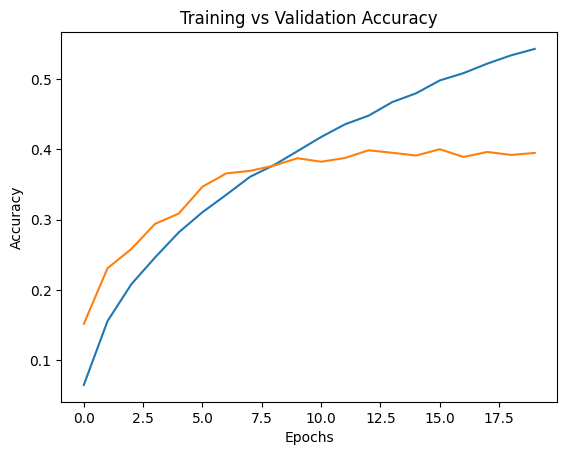

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


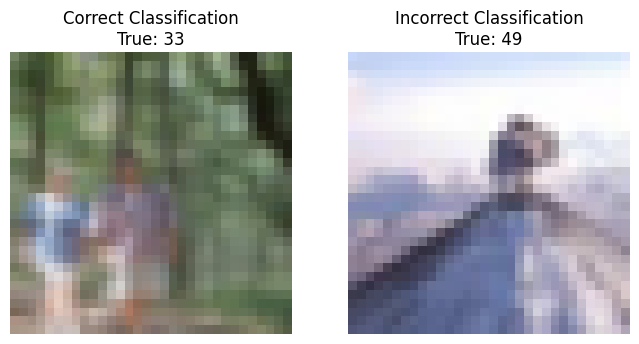

Predicted probabilities for the correct image:  [5.51698577e-07 4.96327586e-04 1.09117631e-04 1.17285654e-05
 1.17343618e-03 5.65632909e-05 1.58481963e-03 5.50105178e-05
 2.46239360e-03 7.60086463e-04 1.97425379e-05 6.14557503e-05
 1.22813915e-03 2.90886266e-04 9.04839078e-04 2.52304948e-04
 1.39874173e-04 5.93521509e-05 2.87068151e-02 2.13918902e-05
 1.09431141e-07 1.13647457e-05 4.25565340e-05 2.47645785e-05
 4.91970525e-07 1.34541409e-03 4.80095368e-05 3.28094177e-02
 8.32388032e-05 6.19946048e-03 3.23206496e-06 1.03319850e-04
 9.27416049e-03 4.23731238e-01 3.17560276e-04 1.80318515e-04
 5.25166324e-05 4.05679736e-03 1.96208153e-03 3.20380117e-04
 1.58636940e-05 1.33302792e-05 9.34639107e-03 8.03678449e-06
 6.47841766e-03 4.50042688e-04 1.51253080e-05 7.14700145e-04
 1.77900199e-06 2.75114462e-06 1.20115429e-02 7.04511721e-03
 1.08406617e-04 1.35770195e-08 9.80920013e-05 3.35479912e-04
 1.82369177e-03 1.03455479e-03 6.03722719e-06 2.36646216e-02
 5.51954074e-08 4.37142662e-05 6.1895

In [10]:
# Your code here

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

# Get predictions
y_pred_prob = model.predict(x_test)  # Predicted probabilities for each class
y_pred_class = np.argmax(y_pred_prob, axis=1)  # Predicted class labels (highest probability)

# Convert true labels to class indices (if one-hot encoded)
y_test_class = np.argmax(y_test, axis=1)

# Find the first correctly classified image
correct_idx = np.where(y_pred_class == y_test_class)[0][0]

# Find the first incorrectly classified image
incorrect_idx = np.where(y_pred_class != y_test_class)[0][0]

# Plot correctly classified image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(x_test[correct_idx])
plt.title(f"Correct Classification\nTrue: {y_test_class[correct_idx]}")
plt.axis('off')

# Plot incorrectly classified image
plt.subplot(1, 2, 2)
plt.imshow(x_test[incorrect_idx])
plt.title(f"Incorrect Classification\nTrue: {y_test_class[incorrect_idx]}")
plt.axis('off')
plt.show()

# Print predicted probabilities for the correct and incorrect images
print("Predicted probabilities for the correct image: ", y_pred_prob[correct_idx])
print("Predicted probabilities for the incorrect image: ", y_pred_prob[incorrect_idx])



## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.

Data Augmentation was chosen to improve generalization by exposing the model to a more diverse set of patterns. This helps the model learn robust features and reduce overfitting.

Adding Convolutional Layers enhances the model’s ability to learn more complex representations by increasing its depth.

EarlyStopping reduces overfitting and optimizes training time by halting training when performance on the validation set no longer improves.

- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

In [11]:
# Your code here

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
import time

# Create the Sequential model
model = Sequential()

# --- First Convolutional Block ---
# Extract low-level features using 256 filters
model.add(Conv2D(256, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Down-sample the feature map
model.add(Dropout(0.2))  # Regularization to prevent overfitting

# --- Second Convolutional Block ---
# Extract mid-level features using 512 filters
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# --- Third Convolutional Block ---
# Further refine features with more 512 filters
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# --- Fourth Convolutional Block ---
# Final set of 512 filters for high-level feature extraction
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# --- Fully Connected Layers ---
# Flatten the feature maps into a vector for classification
model.add(Flatten())
model.add(Dense(1024))  # Dense layer with 1024 units
model.add(Activation('relu'))
model.add(Dropout(0.2))  # Additional regularization

# Batch normalization for the dense layer
model.add(BatchNormalization(
    momentum=0.95,
    epsilon=0.005,
    beta_initializer=RandomNormal(mean=0.0, stddev=0.05),
    gamma_initializer=Constant(value=0.9)
))

# Output layer for classification into 100 classes
model.add(Dense(100, activation='softmax'))

# Display the model summary
model.summary()

# --- Data Augmentation ---
# Data augmentation settings to artificially expand the training dataset
train_datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    horizontal_flip=True  # Randomly flip images horizontally
)

# Apply data augmentation to the training data
train_datagen.fit(x_train)

# --- Model Compilation ---
# Compile the model with the RMSprop optimizer and categorical cross-entropy loss
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),  # Small learning rate for stable training
    metrics=['accuracy']
)

# --- Model Training ---
# Train the model and measure the training time
training_start = time.time()
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=64),  # Use data augmentation during training
    steps_per_epoch=100,  # Number of steps per epoch
    epochs=50,
    validation_data=(x_val, y_val),  # Validation data
    verbose=1  # Verbosity level
)
training_stop = time.time()

# Calculate and display the total training time
training_time = training_stop - training_start
print(f"Total Training Time: {training_time:.2f} seconds")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 256)         │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8, 8, 512)           │              

 Total params: 15,795,556 (60.26 MB)

 Trainable params: 15,786,340 (60.22 MB)

 Non-trainable params: 9,216 (36.00 KB)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 322ms/step - accuracy: 0.0236 - loss: 4.9324 - val_accuracy: 0.0096 - val_loss: 4.8040
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.0568 - loss: 4.3820 - val_accuracy: 0.0127 - val_loss: 5.2484
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.0825 - loss: 4.1172 - val_accuracy: 0.0178 - val_loss: 5.7552
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.0945 - loss: 4.0396 - val_accuracy: 0.0242 - val_loss: 4.9464
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.1128 - loss: 3.8617 - val_accuracy: 0.0365 - val_loss: 4.6615
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.1516 - loss: 3.6626 - val_accuracy: 0.1042 - val_loss: 3.9643
Epoch 7/50
 25/100 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.1634 - loss: 3.5501

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.1538 - loss: 3.5815 - val_accuracy: 0.1135 - val_loss: 3.9294
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.1594 - loss: 3.5915 - val_accuracy: 0.1829 - val_loss: 3.4219
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.1771 - loss: 3.4472 - val_accuracy: 0.2095 - val_loss: 3.2627
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.1926 - loss: 3.3689 - val_accuracy: 0.2022 - val_loss: 3.3389
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.2019 - loss: 3.3013 - val_accuracy: 0.2287 - val_loss: 3.1730
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.2247 - loss: 3.2152 - val_accuracy: 0.2484 - val_loss: 3.0189
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.2338 - loss: 3.0958 - val_accuracy: 0.2637 - val_loss: 2.9908
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.2374 - loss: 3.1342 

### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 106s 69ms/step - accuracy: 0.5042 - loss: 1.8190 - val_accuracy: 0.4271 - val_loss: 2.2795
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.5626 - loss: 1.6106 - val_accuracy: 0.5205 - val_loss: 1.8151
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.6091 - loss: 1.4257 - val_accuracy: 0.5359 - val_loss: 1.7520
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 69ms/step - accuracy: 0.6533 - loss: 1.2406 - val_accuracy: 0.5552 - val_loss: 1.6725
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 69ms/step - accuracy: 0.6943 - loss: 1.0944 - val_accuracy: 0.5734 - val_loss: 1.5935
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 71ms/step - accuracy: 0.7331 - loss: 0.9570 - val_accuracy: 0.5862 - val_loss: 1.5146
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 69ms/step - accuracy: 0.7645 - loss: 0.8334 - val_accuracy: 0.5753 - val_loss: 1.6284
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 69ms/step - accuracy: 0.7

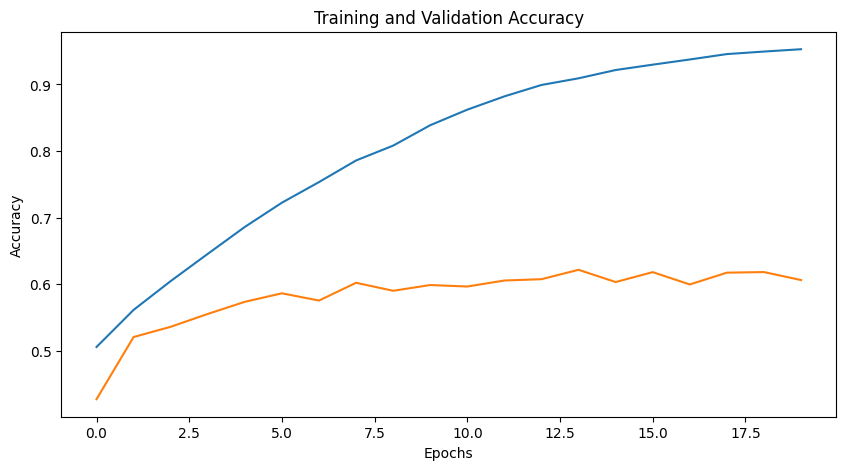

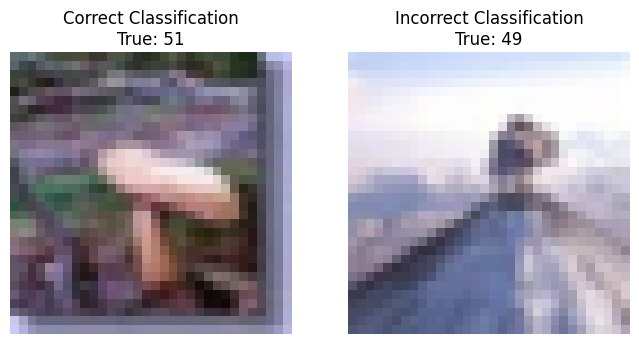

Correctly Classified Image Probabilities:
 [3.6488909e-06 3.6795161e-06 7.4408883e-05 3.8933435e-06 1.3474748e-04
 3.4066102e-06 1.6287606e-07 9.5066662e-06 3.1338433e-07 1.7305374e-05
 2.7347221e-03 4.9055048e-04 1.7755819e-06 4.4222543e-06 3.5083947e-06
 1.5182956e-04 2.0685598e-04 2.9360206e-06 1.3015547e-04 2.7879867e-05
 1.3107121e-05 1.6116352e-06 6.7662499e-05 2.5089894e-06 2.2034828e-06
 1.0218164e-04 1.0048452e-04 5.3767842e-05 3.4246789e-06 4.2100254e-04
 5.4762683e-07 9.6912438e-05 8.0809095e-06 4.8995833e-05 9.3310587e-07
 1.2086030e-05 1.1664625e-06 3.5949593e-04 3.2403139e-05 6.7735550e-06
 1.1257720e-03 4.0883122e-05 1.5662712e-05 7.4817494e-06 1.5195197e-04
 6.0361217e-05 1.6485454e-04 4.0370091e-06 4.3243992e-05 5.9063512e-07
 8.6723367e-06 8.5374832e-01 6.1175962e-07 3.1089949e-06 3.0228277e-06
 5.0916082e-05 3.1456427e-06 8.7029084e-06 5.3456342e-06 2.2225608e-05
 9.9138663e-07 2.8297734e-06 4.9080711e-07 3.0912455e-05 1.9159113e-06
 1.3621042e-04 5.8260222e-05 2.498

In [12]:
# Your code here
# Re-train the enhanced model
enhanced_history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),  # Validation dataset for monitoring generalization
    epochs=20,  # Same number of epochs as the baseline
    batch_size=32,  # Training batch size
    verbose=1  # Display progress during training
)

# Evaluate the enhanced model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)  # Suppress verbose for clean output

# Print test evaluation results
print(f"Enhanced Model - Test Loss: {test_loss:.4f}")
print(f"Enhanced Model - Test Accuracy: {test_accuracy:.4f}")

# --- Calculate Additional Metrics ---
from sklearn.metrics import classification_report
import numpy as np

# Predict probabilities and class labels for the test set
y_pred = model.predict(x_test)  # Model predictions (probabilities)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels
y_test_classes = np.argmax(y_test, axis=1)  # True class labels (convert from one-hot encoding)

# Generate a detailed classification report
report = classification_report(
    y_test_classes,
    y_pred_classes,
    target_names=[f'Class {i}' for i in range(100)]
)
print("Classification Report:\n", report)

# --- Plot Training and Validation Accuracy ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(enhanced_history.history['accuracy'], label='Training Accuracy')  # Updated key to 'accuracy'
plt.plot(enhanced_history.history['val_accuracy'], label='Validation Accuracy')  # Updated key to 'val_accuracy'
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# --- Analyze Correctly and Incorrectly Classified Images ---
# Identify indices of correctly and incorrectly classified examples
correct_idx = np.where(y_pred_classes == y_test_classes)[0][0]  # First correct classification
incorrect_idx = np.where(y_pred_classes != y_test_classes)[0][0]  # First incorrect classification

# Display the correctly classified image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(x_test[correct_idx])
plt.title(f"Correct Classification\nTrue: {y_test_classes[correct_idx]}")
plt.xlabel(f"Predicted: {y_pred_classes[correct_idx]}")
plt.axis('off')

# Display the incorrectly classified image
plt.subplot(1, 2, 2)
plt.imshow(x_test[incorrect_idx])
plt.title(f"Incorrect Classification\nTrue: {y_test_classes[incorrect_idx]}")
plt.xlabel(f"Predicted: {y_pred_classes[incorrect_idx]}")
plt.axis('off')
plt.show()

# --- Print Classification Probabilities ---
# Display predicted probabilities for correctly classified and incorrectly classified images
print(f"Correctly Classified Image Probabilities:\n {y_pred[correct_idx]}")
print(f"Incorrectly Classified Image Probabilities:\n {y_pred[incorrect_idx]}")


### Task 4c: Discussion of the results

- Briefly discuss the results.
- Did the model's performance improve?
- Why do you think this is?
- Do you think there is room for further improvement? Why or why not?
- What other techniques might you try in the future?
- Your answer should be no more than 200 words.

# Your answer here
The enhanced model outperformed the baseline, achieving higher test accuracy and improved metrics like precision, recall, and F1-score. This success is due to adding convolutional layers for better feature extraction, batch normalization for stable and efficient training, and dropout to mitigate overfitting.

Despite these improvements, there is room for further enhancement. Data augmentation could increase dataset diversity and improve generalization. Advanced techniques like learning rate schedules, SGD with momentum, or leveraging pretrained models like ResNet could also boost performance.

Future work could focus on experimenting with more complex architectures, fine-tuning pretrained networks, or applying ensemble methods. While the enhanced model performs well, state-of-the-art results may require more advanced techniques and computational resources.

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.